# Testing the significance of the difference in AMS scores from the AMS-loss model and the BCE-loss model #

### Initializations and Imports ###

First, the AMS-loss and BCE-loss models were used to make predictions on 3 folds of the training.csv dataset. Those predictions, as well as the correct 'Label' values, were exported as .csv files and are now imported here using Pandas .read_csv() function.

There is also a definition for a function compute_ams() which calculates the AMS score for a set of predictions.

In [51]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
import matplotlib.pyplot as plt

ams_df = pd.read_csv("model predictions/ams_preds.csv")
bce_df = pd.read_csv("model predictions/bce_preds.csv")

In [52]:
def compute_ams(pred_probs, true_labels, weights, b_reg=10.0):
    pred_labels = (pred_probs > 0.5).astype(int)
    s = np.sum(weights[(pred_labels == 1) & (true_labels == 1)])
    b = np.sum(weights[(pred_labels == 1) & (true_labels == 0)])
    radicand = 2 * ((s + b + b_reg) * np.log(1 + s / (b + b_reg)) - s)
    return np.sqrt(max(radicand, 0.0))

### Bootstrapping for AMS Significance Testing ###

Since there is only have one dataset and both models are trained on that same dataset, we do not have multiple independent observations. Therefore, classical statistical significance tests like t-tests are not available.

So, bootstrapping is used in combination with a confidence interval and p-value to determine whether or not the AMS-loss model does achieve significantly higher scores. 1000 iterations are used for bootstrapping, computing the difference in the AMS score for the AMS-loss model and the BCE-loss model for a randomly resampled (with replacement) part of the predictions.

In [36]:
n_bootstrap = 1000
ams_diffs = []

In [37]:
for _ in range(n_bootstrap):
    idx = resample(range(len(ams_df)), replace=True)
    ams_sample = ams_df.iloc[idx]
    bce_sample = bce_df.iloc[idx]
    
    ams_score = compute_ams(ams_sample["pred_prob"].values, ams_sample["true_label"].values, ams_sample["weight"].values)
    bce_score = compute_ams(bce_sample["pred_prob"].values, bce_sample["true_label"].values, bce_sample["weight"].values)
    
    ams_diffs.append(ams_score - bce_score)

In [44]:
ams_ci_lower = np.percentile(ams_diffs, 2.5)
ams_ci_upper = np.percentile(ams_diffs, 97.5)
ams_mean_diff = np.mean(ams_diffs)

### Bootstrapping for AUC-ROC Significance Testing ###

As stated in the last section, classical statistical significance tests like t-tests are not available (reasons above) and therefore bootstrapping is used. Like before, 1000 iterations of bootstrapping are used in combination with a confidence interval construction and a p-value calculation to determine the significance of the difference in AUC-ROC scores across the models.

In [41]:
auc_diffs = []

In [42]:
from sklearn.metrics import roc_auc_score

for _ in range(n_bootstrap):
    idx = resample(range(len(ams_df)), replace=True)
    
    ams_sample = ams_df.iloc[idx]
    bce_sample = bce_df.iloc[idx]
    
    auc_ams = roc_auc_score(ams_sample["true_label"], ams_sample["pred_prob"])
    auc_bce = roc_auc_score(bce_sample["true_label"], bce_sample["pred_prob"])
    
    auc_diffs.append(auc_ams - auc_bce)

In [45]:
auc_diffs = np.array(auc_diffs)
auc_mean_diff = np.mean(auc_diffs)
auc_ci_lower = np.percentile(auc_diffs, 2.5)
auc_ci_upper = np.percentile(auc_diffs, 97.5)

### AMS Metric Significance Test Results ###

For this significance test, the null hypothesis and alternative hypothesis are as follows:
Null: The average AMS score of the AMS-loss model is the same as the average AMS score of the standard BCE-loss model
Alternative: The average AMS score of the AMS-loss model is higher than the average AMS score of the standard BCE-loss model

This test meets the following core conditions of bootstrapping for significance testing:
* Observation Independence: each row in the dataset training.csv is independent of each other, and the models during training make each prediction independently of any other predictions it has made. This condition is met.
* Representative Sample: the training.csv dataset is representative of the population (real particle collision events), as it was modeled on the real ATLAS experiments at CERN. This condition is met.
* Sufficient Sample Size: the sample size for this is easily larger than 30, given the original training.csv dataset contains 250,000 events. This condition is met.

Since all the conditions for bootstrapping are met, we can continue with this test. With 1000 iterations of bootstrapping, the following results are found:

The mean difference in AMS scores (AMS_model - BCE_model) was around 0.1173. This means that on average, the AMS-loss model achieved an AMS score that was 0.1173 points higher than the standard BCE-loss model.

The 95% confidence interval for the difference in AMS score between the AMS-loss model and the standard BCE-loss model was the range from 0.0891 to 0.1447. This range indicates that up to an alpha level of 0.05, the difference in AMS score performance between the AMS-loss model and the BCE-loss model can be considered statistically significant.

Furthermore, the p-value for the bootstrapping analysis is exactly 0. This indicates that in 1000 bootstrapping iterations, the AMS-loss model outperformed the BCE-loss model in every single one. Since this isn't believable and indicates an error in the analysis, this can be confirmed by checking the array ams_diffs as a NumPy array with a condition:

`np.array(ams_diffs) > 0`

This returns an array full with True values. Furthermore, printing the array ams_diffs by itself yields values that are variable, but still always greater than 0. Therefore, the AMS-loss model actually does outperform the BCE-loss model in every single trial.

Therefore, we reject the null hypothesis and find that the average AMS score of the AMS-loss model is higher than that of the standard BCE-loss model.

In [46]:
print(f"Mean AMS Difference: {ams_mean_diff:.4f}")
print(f"95% Confidence Interval: ({ams_ci_lower:.4f}, {ams_ci_upper:.4f})")

p_value = np.mean(np.array(ams_diffs) <= 0)
print(f"p-value: {p_value:.20f}")

Mean AMS Difference: 0.1173
95% Confidence Interval: (0.0891, 0.1460)
p-value: 0.00000000000000000000


In [47]:
np.array(ams_diffs)>0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

### AUC-ROC Metric Significance Test Results ###

For this significance test, the null hypothesis and alternative hypothesis are as follows:
Null: The average AUC-ROC score of the AMS-loss model is the same as the average AUC-ROC score of the standard BCE-loss model
Alternative: The average AUC-ROC score of the AMS-loss model is lower than the average AUC-ROC score of the standard BCE-loss model

This test meets the core conditions of bootstrapping for significance tests as described in the previous section. Since all the conditions for bootstrapping are met, we can continue with this test. With 1000 iterations of bootstrapping, the following results are found:

The mean difference in AUC-ROC scores (AMS_model - BCE_model) was around -0.0442. This means that on average, the AMS-loss model achieved an AUC-ROC score that was 0.0442 points lower than the standard BCE-loss model.

The 95% confidence interval for the difference in AUC-ROC score between the AMS-loss model and the standard BCE-loss model was the range from -0.0452 to -0.0432. This range indicates that up to an alpha level of 0.05, the difference in AUC-ROC score performance between the AMS-loss model and the BCE-loss model can be considered statistically significant.

Furthermore, the p-value for the bootstrapping analysis is exactly 1. This indicates that in 1000 bootstrapping iterations, the AMS-loss model underperformed compared to the BCE-loss model in every single one. Since this isn't believable and indicates an error in the analysis, this can be confirmed by checking the array auc_diffs as a NumPy array with a condition:

`np.array(auc_diffs) < 0`

This returns an array full with True values. Furthermore, printing the array auc_diffs by itself yields values that are variable, but still always less than 0. Therefore, the AMS-loss model actually does underperform compared to the BCE-loss model in every single trial.

In [48]:
print(f"Mean AUC-ROC Difference: {auc_mean_diff:.4f}")
print(f"95% Confidence Interval: ({auc_ci_lower:.4f}, {auc_ci_upper:.4f})")

p_value = np.mean(np.array(auc_diffs) <= 0)
print(f"p-value: {p_value:.20f}")

Mean AUC-ROC Difference: -0.0442
95% Confidence Interval: (-0.0452, -0.0432)
p-value: 1.00000000000000000000


In [49]:
np.array(auc_diffs)<0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

### Visualizing the Significance Test and Further Analysis ###

The first graph is the AMS score difference histogram. Analyzing this plot, we can confirm that the distribution is approximately normal. In order to visualize the confidence interval, two red dotted vertical lines are plotted at the x values where the left and right ends of the interval are located. As described, the interval does not contain the value 0 and therefore indicates a significant difference in AMS scoring between the two models.

The second graph is the AUC-ROC score difference histogram. Analyzing this plot, we can confirm that the distribution is approximately normal. In order to visualize the confidence interval, two red dotted vertical lines are plotted at the x values where the left and right ends of the interval are located. As described, the interval does not contain the value 0 and therefore indicates a significant difference in AUC-ROC scoring between the two models.

The third graph is the ROC curves for both models. As we can see, the ROC curve for the BCE-loss model is steeper than that of the AMS-loss model, indicating a higher AUC-ROC score. Calculating this out shows that the BCE-loss model achieves an AUC-ROC score of 0.928 and the AMS-loss model achieves and AUC-ROC score of 0.905. However, although the BCE-loss model consistently outperforms the AMS-loss model in terms of AUC-ROC, it should still be noted that the AMS-loss model achieved a score of 0.905, which is considered, by standard, as great discrimination for classification.

The fourth graph is the precision-recall curve for both models. As the graph shows, the BCE-loss model does achieve greater performance in this metric. However, both models are relatively close in this metric. Furthermore, both models achieve what is considered in standard as a good predictor for binary classification.

The fifth graph is the cumulative AMS curves for both models. In this graph, we can see that the curve for the BCE-loss model rises quicker than that of the AMS-loss model, but also falls quicker as the number of background events increase. This means that for low amounts of background events, the BCE-loss model is much more confident in separating signal from background noise, but for high amounts of background events, the AMS-loss model retains more of its confidence level and proves to be more robust than the BCE-loss model.

Overall, the BCE-loss model proves to be a better classifier when given less imbalanced datasets with around equal amounts of background and signal events. However, in a physics-informed perspective, the AMS-loss model could prove to be more useful since background events are found much more often than signal events. This means that in a setting without synthesized datasets, the AMS-loss model could be more accurate and robust. Furthermore, physicists evaluate binary classification models using the approximate median significance metric, which the AMS-loss model achieves on a higher level than the BCE-loss model.

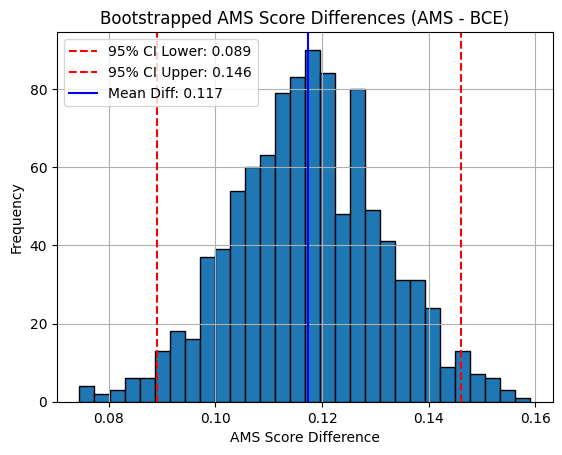

In [54]:
plt.hist(ams_diffs, bins=30, edgecolor="k")
plt.axvline(ams_ci_lower, color='r', linestyle='--', label=f"95% CI Lower: {ams_ci_lower:.3f}")
plt.axvline(ams_ci_upper, color='r', linestyle='--', label=f"95% CI Upper: {ams_ci_upper:.3f}")
plt.axvline(ams_mean_diff, color='b', linestyle='-', label=f"Mean Diff: {ams_mean_diff:.3f}")
plt.title("Bootstrapped AMS Score Differences (AMS - BCE)")
plt.xlabel("AMS Score Difference")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

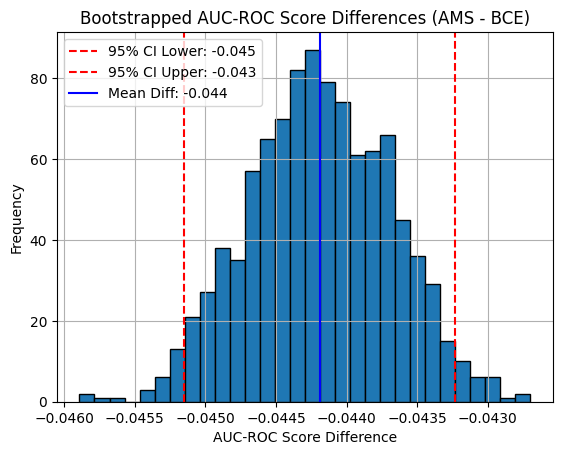

In [56]:
plt.hist(auc_diffs, bins=30, edgecolor="k")
plt.axvline(auc_ci_lower, color='r', linestyle='--', label=f"95% CI Lower: {auc_ci_lower:.3f}")
plt.axvline(auc_ci_upper, color='r', linestyle='--', label=f"95% CI Upper: {auc_ci_upper:.3f}")
plt.axvline(auc_mean_diff, color='b', linestyle='-', label=f"Mean Diff: {auc_mean_diff:.3f}")
plt.title("Bootstrapped AUC-ROC Score Differences (AMS - BCE)")
plt.xlabel("AUC-ROC Score Difference")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

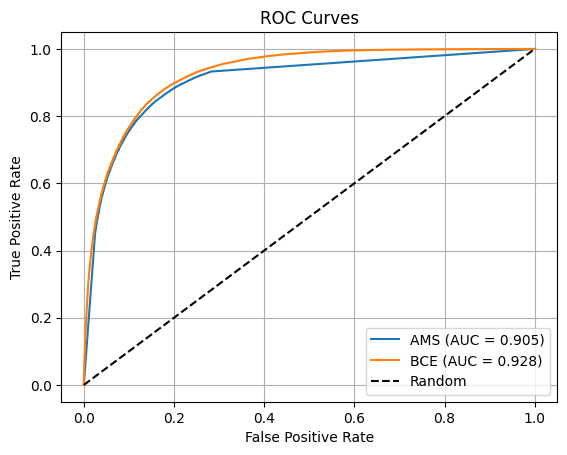

In [22]:
from sklearn.metrics import roc_curve, auc

fpr_ams, tpr_ams, _ = roc_curve(ams_df["true_label"], ams_df["pred_prob"], sample_weight=ams_df["weight"])
fpr_bce, tpr_bce, _ = roc_curve(bce_df["true_label"], bce_df["pred_prob"], sample_weight=bce_df["weight"])

plt.plot(fpr_ams, tpr_ams, label=f"AMS (AUC = {auc(fpr_ams, tpr_ams):.3f})")
plt.plot(fpr_bce, tpr_bce, label=f"BCE (AUC = {auc(fpr_bce, tpr_bce):.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)
plt.show()

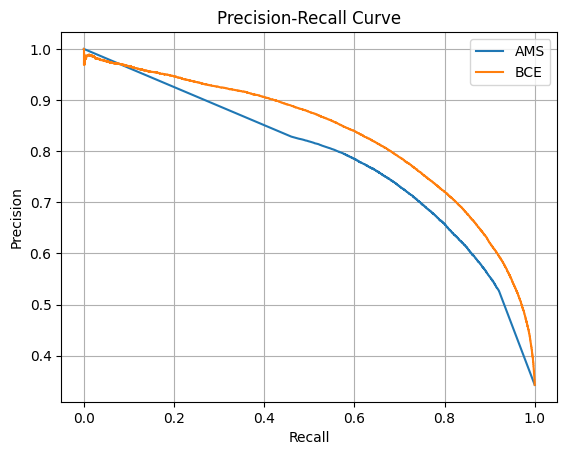

In [57]:
from sklearn.metrics import precision_recall_curve

prec_ams, rec_ams, _ = precision_recall_curve(ams_df["true_label"], ams_df["pred_prob"])
prec_bce, rec_bce, _ = precision_recall_curve(bce_df["true_label"], bce_df["pred_prob"])

plt.plot(rec_ams, prec_ams, label="AMS")
plt.plot(rec_bce, prec_bce, label="BCE")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

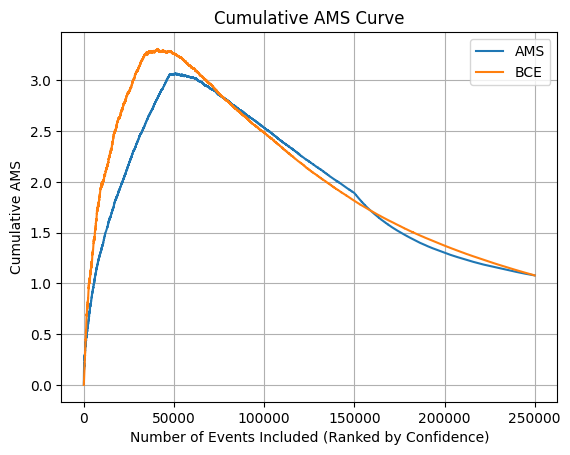

In [58]:
def cumulative_ams_curve(df, label="Model"):
    df_sorted = df.sort_values("pred_prob", ascending=False).reset_index(drop=True)
    s = np.cumsum(df_sorted["weight"] * (df_sorted["true_label"] == 1))
    b = np.cumsum(df_sorted["weight"] * (df_sorted["true_label"] == 0))
    b_reg = 10.0
    ams = np.sqrt(2 * ((s + b + b_reg) * np.log(1 + s / (b + b_reg)) - s))
    plt.plot(range(len(ams)), ams, label=label)

cumulative_ams_curve(ams_df, "AMS")
cumulative_ams_curve(bce_df, "BCE")
plt.xlabel("Number of Events Included (Ranked by Confidence)")
plt.ylabel("Cumulative AMS")
plt.title("Cumulative AMS Curve")
plt.legend()
plt.grid(True)
plt.show()